# TODOs

## Techinical
- Try use plain BERT Rob
- RAG Paolo
- shakespear
- Checkpoints for outcome prediction

## Chores
- Setting up model on hugging face
- How to use the dataset from hugging face
- How to use the mdoel from hugging face
- Clean the github repo
- Make a question list
- Make a usable pip package from the repo
- write a README

# Group Assignment NLP course 2024/2025

## Group: NLP Processors
* Ginefra Paolo
* Onori Ferdinando
* Missana Martina
* Uhrich Robin

##  Dataset: [Strategic Game Chess](https://huggingface.co/datasets/laion/strategic_game_chess)

The dataset used contains data on chess games generated through self-play **Stockfish** engine using **Fugaku** (a supercomputer in Kobe, Japan) adding initial moves to expand the diversity. It contains **3.2 billion games** with approximately 608 billion moves.

Due to computational constraints we decided to work just on the first parquet file of the dataset, containing the first **100.000 games**. 

Each game in the dataset is composed of three columns:
* **Move**: a sequence of all the moves made during the game.

* **Termination**: the condition under which the game ended. Possible values include: 
    - `CHECKMATE`
    - `INSUFFICIENT MATERIAL`
    - `FIVEFOLD_REPETITION`
    - `SEVENTYFIVE_MOVES`
    - `STALEMATE`
* **Result**: result of the game
    - `1-0`         (White wins)
    - `1/2-1/2`     (Draw)
    - `0-1`         (Black wins)

 #### **Data Wrangling**

To facilitate the use of the dataset and ensure all necessary information is available for the project, a set of Parquet files was created with the following structure:
* **Moves**

* **Termination**

* **Result**

* **Pieces**: the piece moved in every move

* **Captures**: the type of piece captured (if any) at each move.

* **Checks**: a boolean value indicating whether a move resulted in a check (`true` or `false`)

* **Next_move**: the move sequence shifted by one position, useful for predictive modeling tasks

* **Result_seqs**: a repeated sequence of the final result, aligned with the length of the move sequence for each game


In addition, two YAML files were created to support data processing:

- **Move Lookup Table**  

  A mapping of all possible moves to unique integer identifiers.

- **Result Lookup Table**  

  A mapping of game results (`1-0`, `0-1`, `1/2-1/2`) to numerical labels, useful for classification tasks.


All the files used were uploaded on **Hugging Face**

#### TODOs:
* explaining why we used just one parquet file
* creation of the dataset
* our goal for the project (how much chess lang is a natural lang)
* disclaimer that we stick the dataset as closely as possible with assumingnot  having knowledge ofunderlyingmodelof chess

### 1. Preliminary Analysis

#### TODOs:
* Data Exploration (type of data, structure, vocaboulary, ...) - verbose stuff
* graph - verbose stuff
* Zipf's Law
* usage of move visualizer/ move plotter
* clustering (Australia  plot) (Paolo explaining if  clusters make sens)
* word2vec and embeddings (Paolo)
* move distribution(martina)
* FEN distribution (Ferdinando)
* skipgrams n-grams(matrices, dendrograms(?))

### 2. Training Models

#### TODOs:
* LAMA
* LSTM
* RAG (Paolo)
* Transformer (plots)
* Zeroshot-multishot(?)(Ferdinando)


### 3. Possible Extensions

#### TODOs:
* chessbots with game entropy etc. (lstm,ferdinando,voice)

(menu and intuition)

### 4. Conclusions (?)

* adding knowledge should result in better performances...
* computationalconstraintsssss
* chess grammar

## How are the piece moved distributed across the games?

To answer this question, let's do some statistical analysis on the pieces moved

Load the dataset

In [10]:
import chess
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from collections import Counter
from datasets import load_dataset
import tqdm
import seaborn as sns
sns.set_theme()

%load_ext autoreload
%autoreload 2

In [2]:
from nlpChess.utils.DatasetLoader import loadConcatenatedDataset
ds = loadConcatenatedDataset()
df = ds.to_pandas()

Let's create new columns containing the sequence of pieces moved in each phase of the game.

In [4]:
len_games = df['Moves'].apply(len)
openingLimit = len_games*0.1
midgameLimit = len_games*0.3
endgameLimit = len_games.apply(lambda x:max(x, 31))

In [5]:
df['Opening'] = df.apply(lambda row: row['pieces'][:int(openingLimit.loc[row.name])], axis=1)
df['Midgame'] = df.apply(lambda row: row['pieces'][int(openingLimit.loc[row.name]):int(midgameLimit.loc[row.name])], axis=1)
df['Endgame'] = df.apply(lambda row: row['pieces'][int(midgameLimit.loc[row.name]):int(endgameLimit.loc[row.name])], axis=1)

To start the analysis it is computed the average move distribution per piece across all games

In [8]:
pieces = df['pieces']
# Concatenate all pieces from all games into a single list
all_pieces = np.concatenate(pieces.values)

In [11]:
# count the number of pieces and relative frequencies
piece_counts = Counter(all_pieces)
piece_counts = dict(piece_counts)
piece_counts = {k: v for k, v in sorted(piece_counts.items(), key=lambda item: item[1], reverse=True)}
# Create a DataFrame from the piece counts
piece_counts_df = pd.DataFrame.from_dict(piece_counts, orient='index', columns=['count'])
piece_counts_df['relative_frequency'] = piece_counts_df['count'] / piece_counts_df['count'].sum()
piece_counts_df 

,count,relative_frequency
k,5066635,0.267344
r,4202215,0.221732
p,3034835,0.160135
b,2699589,0.142445
n,2153684,0.113640
q,1794775,0.094702


Plot the average move distribution per piece across all games

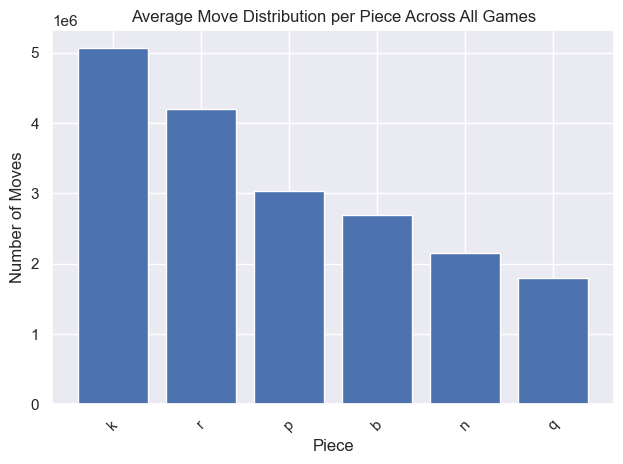

In [12]:
plt.bar(piece_counts_df.index, piece_counts_df['count'])
plt.title("Average Move Distribution per Piece Across All Games")
plt.xlabel("Piece")
plt.ylabel("Number of Moves")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the plot it is evident that the most moved piece is the king, and since the king is not used in the early part of games, it can be assumed that our games have a long ending phase.

Let's apply the same analysis to the pieces moved but divided by phase of the game to see if Stockfish uses  different pieces in different phases .

In [13]:
opening_pieces = np.concatenate(df['Opening'].values)
midgame_pieces = np.concatenate(df['Midgame'].values)
endgame_pieces = np.concatenate(df['Endgame'].values)

In [14]:
def piece_distribution(pieces_array):
    counts = Counter(pieces_array)
    counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
    df_counts['relative_frequency'] = df_counts['count'] / df_counts['count'].sum()
    return df_counts

opening_piece_counts_df = piece_distribution(opening_pieces)
midgame_piece_counts_df = piece_distribution(midgame_pieces)
endgame_piece_counts_df = piece_distribution(endgame_pieces)

print("Opening:\n", opening_piece_counts_df)
print("\nMidgame:\n", midgame_piece_counts_df)
print("\nEndgame:\n", endgame_piece_counts_df)

Opening:
     count  relative_frequency
p  839313            0.453768
n  464192            0.250962
b  307876            0.166451
q  101961            0.055124
k   89141            0.048193
r   47170            0.025502

Midgame:
     count  relative_frequency
p  884560            0.233380
r  723732            0.190947
b  701864            0.185178
n  642586            0.169538
q  465006            0.122686
k  372467            0.098271

Endgame:
      count  relative_frequency
k  4605027            0.345934
r  3431313            0.257764
b  1689849            0.126943
p  1310962            0.098481
q  1227808            0.092234
n  1046906            0.078645


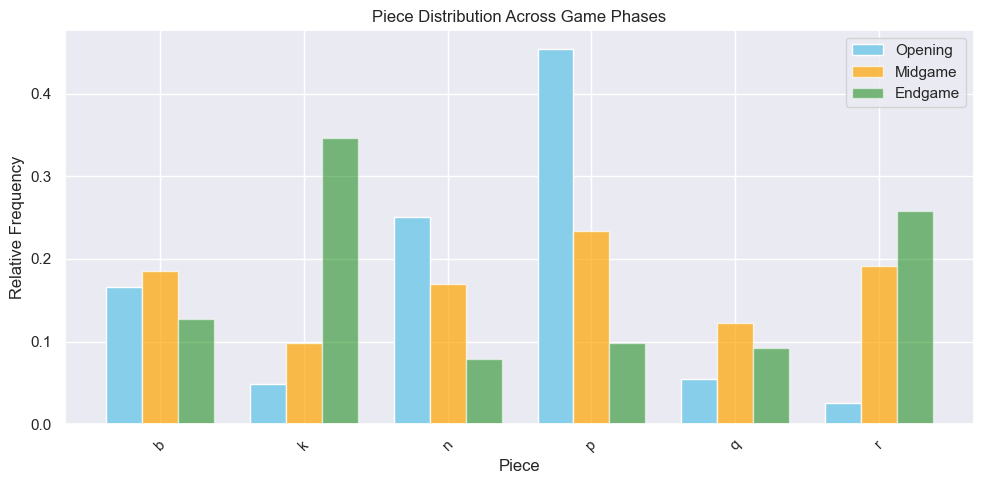

In [15]:
all_pieces = sorted(set(opening_piece_counts_df.index) | set(midgame_piece_counts_df.index) | set(endgame_piece_counts_df.index))

opening_freqs = [opening_piece_counts_df['relative_frequency'].get(piece, 0) for piece in all_pieces]
midgame_freqs = [midgame_piece_counts_df['relative_frequency'].get(piece, 0) for piece in all_pieces]
endgame_freqs = [endgame_piece_counts_df['relative_frequency'].get(piece, 0) for piece in all_pieces]

x = np.arange(len(all_pieces))
width = 0.25

plt.figure(figsize=(10, 5))
plt.bar(x - width, opening_freqs, width, label='Opening', color='skyblue')
plt.bar(x, midgame_freqs, width, label='Midgame', color='orange', alpha=0.7)
plt.bar(x + width, endgame_freqs, width, label='Endgame', color='green', alpha=0.5)
plt.title("Piece Distribution Across Game Phases")
plt.xlabel("Piece")
plt.ylabel("Relative Frequency")
plt.xticks(x, all_pieces, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


From the plot, the relative frequency suggests that:

* Pawns are the most used pieces in the early phase of the game.

* The king is the most moved piece in the endgame.

This aligns with standard chess strategy, making it a meaningful result.

Let's now plot a heatmap that, for each move number, highlights the count of pieces moved by type.

In [16]:
# dataframe with the index+1 of every piece in df['pieces']
def get_piece_indices(pieces):
    piece_indices = []
    for piece in pieces:
        indices = [i + 1 for i, p in enumerate(piece) if p != '0']
        piece_indices.append(indices)
    return piece_indices
df['piece_indices'] = get_piece_indices(df['pieces'])

In [17]:
# put together df['piece_indices'] and df['pieces'] in a new dataframe
piece_indices_df = pd.DataFrame({
    'piece_indices': df['piece_indices'].explode(),
    'pieces': df['pieces'].explode()
})

In [18]:
#group by  move_number and piece
df_count = piece_indices_df.groupby(['piece_indices', 'pieces']).size().reset_index(name='count')

Once created the dataframe containing all the information needed let's plot the heatmap.

In [20]:
#normalize  by  move_number
df_count['normalized_count'] = df_count['count'] / df_count.groupby('piece_indices')['count'].transform('sum')

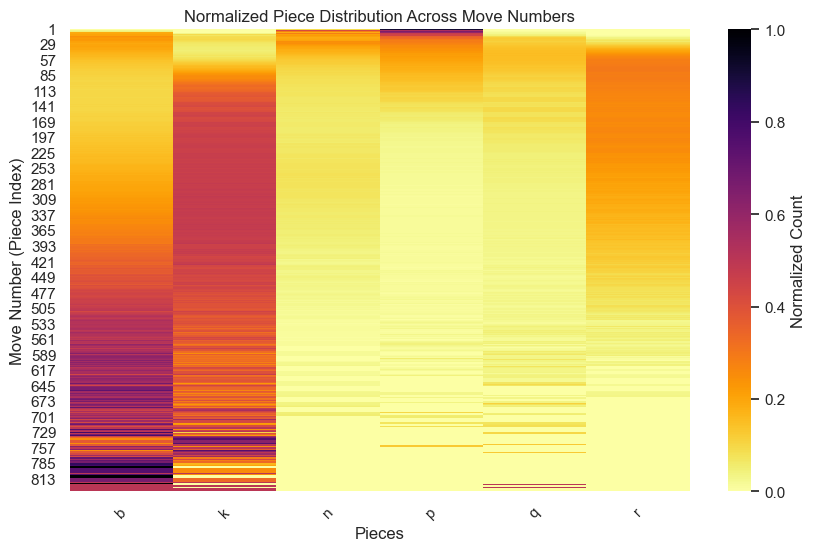

In [21]:
#heatmap of the normalized counts
pivot_table = df_count.pivot(index='piece_indices', columns='pieces', values='normalized_count').fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='inferno_r', fmt='.2f', cbar_kws={'label': 'Normalized Count'})
plt.title("Normalized Piece Distribution Across Move Numbers")
plt.xlabel("Pieces")
plt.ylabel("Move Number (Piece Index)")
plt.xticks(rotation=45)
plt.show()

From the heatmap it is possible to see the opening phase (with the pawns being the most moved pieces), and than the ending phase, played almost entirely by bishops and king.

It is also worth noting that the game are very long with respect to a normal chess game (due to the fact that they are played by Stockfish).

## How much is move language of chess related to a Natural Language?

In order to answer this question the idea was to apply the Zipf`s Law to the dataset trying to compare it with a classic Natural Language such as english language.

#### Zipf's Law

The comparison was made between the chess dataset and a dataset containing the plays of Shakespear (with the assumption of Shakespear as a good representation of english language), to understand if the sequence of moves in chess could be identified as Natural Language.

The Zipf`s Law is defined as: 

$f(r) = \frac{C}{r^s}$

where f(r) is the frequency of the word at rank r, C is a constant, and s is the Zipf`s exponent.

The Zipf's exponent is useful to answer the question proposed since:

- if **s<1**: The distribution flattens. Frequencies are more evenly spread across ranks, indicating a more uniform distribution of items.
- if **s=1**: The classic Zipfian case. The second-ranked item occurs half as frequently as the first, and so on. This implies that a few words are extremely common, and many are rare. The classic natural languages are usually Zipfian.
- if **s>1**: The distribution is steeper.
    High-ranked items dominate, and lower-ranked items become significantly rare. 
    This suggests a system where a few elements are overwhelmingly prevalent.

The exponent can be computed by finding ranks and sequences of the tokens and estimating the exponent from their plot.

Source for Zipf's Law exponent for natural languages: [here](https://www.sciencedirect.com/science/article/pii/S0375960117305388)

In [43]:
import chess
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from collections import Counter
from datasets import load_dataset
import tqdm
import seaborn as sns
sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the dataset

In [22]:
from nlpChess.utils.DatasetLoader import loadConcatenatedDataset
ds = loadConcatenatedDataset()
df = ds.to_pandas()

Let's remove the fifth character from the tokens since the castle is not important for our task since we just look at the moves on the checkboard

In [23]:
def removeFifthChar(string):
    if len(string) < 5:
        return string
    return string[:4]

#Apply the function to the 'moves' column
df['moves'] = df['Moves'].apply(removeFifthChar)

Let's create a move list containing the moves of all the games.

In [24]:
# Get all the performed moves
# Concatenate all moves from all games into a single list
moves = [move for game in df['Moves'] for move in game]

It is possible now to count the occurences of each move and sort the results by frequency to see if Zipf's law is applied.

In [25]:
# Count the occurrences of each move
move_counts = Counter(moves)

# Sort the moves by frequency
sorted_move_counts = move_counts.most_common()
move_ranks = range(1, len(sorted_move_counts) + 1)
move_frequencies = [count for fen, count in sorted_move_counts]

Let's plot the result. Since the scale is logarithmic for both axes, if the language has an exponent close to one the plot should almost be a line with slope of -1

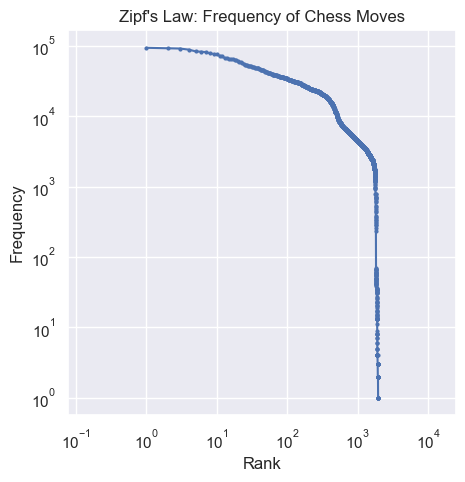

In [26]:
plt.figure(figsize=(5, 5))
plt.loglog(move_ranks, move_frequencies, marker='o', markersize=2)
plt.title("Zipf's Law: Frequency of Chess Moves")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.axis('equal') 
plt.show()

Now it is possiblet to try estimating the Zipf's exponent for this dataset

In [27]:
log_move_ranks = np.log(move_ranks)
log_move_freqs = np.log(move_frequencies)
move_coeffs = np.polyfit(log_move_ranks, log_move_freqs, 1)
move_slope = move_coeffs[0]
print(f"Estimated Zipf exponent for moves: {abs(move_slope):.2f}")

Estimated Zipf exponent for moves: 1.28


From the previous code it is possible to see that the chess language of our dataset has a Zipf`s exponent of **1.28**, pretty close to the Zipfian case, but the shape of the plot is not very close to the Zipfian case.
The exponent could be a sign of it being a Natural Language but the big nonlinearity could be causing a bias in the exponent computation

Let's do some more analysis taking into account the Shakespear data

In [28]:
from nlpChess.utils.DatasetLoader import loadConcatenatedShakespeareDataset
dsShakespeare = loadConcatenatedShakespeareDataset()
dfShakespeare = dsShakespeare.to_pandas()
dfShakespeare.head()

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,19217,19218,Antony and Cleopatra,9.0,2.1.33,POMPEY,"How now, Varrius!"
1,99413,99414,Troilus and Cressida,32.0,1.2.66,CRESSIDA,"Ay, if I ever saw him before and knew him."
2,104667,104668,Twelfth Night,86.0,3.4.193,VIOLA,With the same 'havior that your passion bears
3,41989,41990,Henry VIII,41.0,3.2.121,SUFFOLK,"May be, he hears the king"
4,36553,36554,Hamlet,119.0,5.2.312,HAMLET,"Nay, come, again."


Join the lines of the plays together and tokenize the lines into words.

In [29]:
lines = dfShakespeare['PlayerLine'].tolist()
lines = ' '.join(lines)
lines[:100]
shakespearWritings = lines.split()

Application of the Zipf's Law, plot and estimation of the exponent.

In [30]:
word_counts = Counter(shakespearWritings)
# Sort the words by frequency
sorted_word_counts = word_counts.most_common()
word_ranks = range(1, len(sorted_word_counts) + 1)
word_frequencies = [count for word, count in sorted_word_counts]


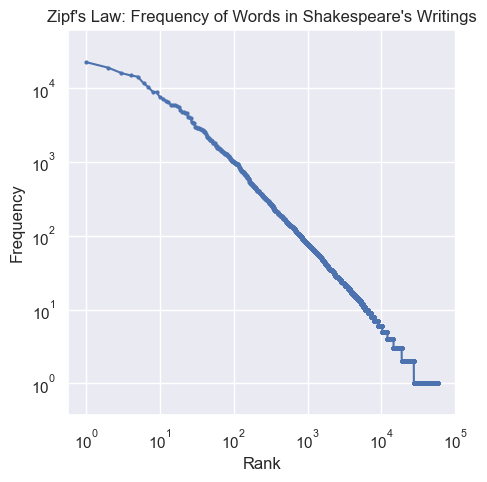

In [31]:
plt.figure(figsize=(5, 5))
plt.loglog(word_ranks, word_frequencies, marker='o', markersize=2)
plt.title("Zipf's Law: Frequency of Words in Shakespeare's Writings")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.axis('equal')
plt.show()

In [32]:
log_word_ranks = np.log(word_ranks)
log_word_freqs = np.log(word_frequencies)
word_coeffs = np.polyfit(log_word_ranks, log_word_freqs, 1)
word_slope = word_coeffs[0]
print(f"Estimated Zipf exponent in Shakespear's writings: {abs(word_slope):.2f}")

Estimated Zipf exponent in Shakespear's writings: 1.14


From these results it is possible to see that also this exponent is close to the Zipfian case, but in this plot we can easily see that the data almost form a precise line with slope -1.

The difference between the two languages is pretty visible in the following plot.

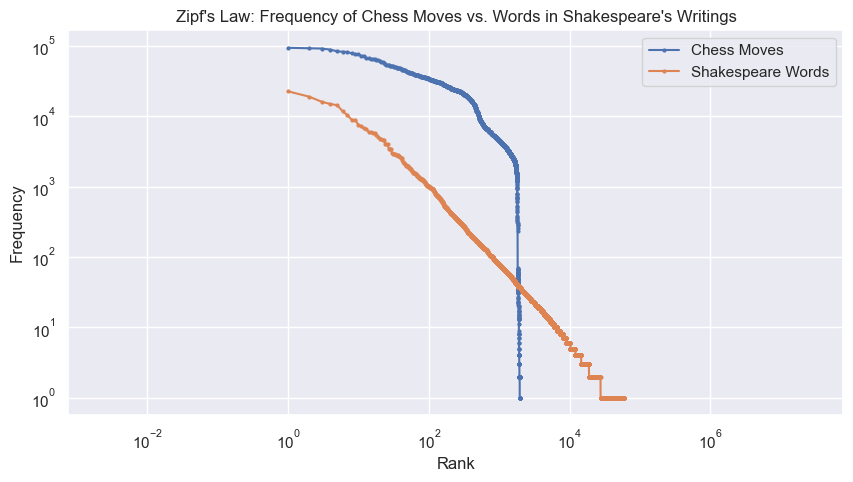

In [33]:
#Compare on the same plot the chess plot and the Shakespear one
plt.figure(figsize=(10, 5))
plt.loglog(move_ranks, move_frequencies, marker='o', label="Chess Moves", markersize=2)
plt.loglog(word_ranks, word_frequencies, marker='o', label="Shakespeare Words", markersize=2)
plt.title("Zipf's Law: Frequency of Chess Moves vs. Words in Shakespeare's Writings")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.axis('equal')
plt.show()

Now it is possible to analyze if the phase of the game in which the move is performed is important in terms of Zipf's Law. 

Is there a game phase where the language is similar to a Natural Language?

The games were divided into three phases:
* **Opening**: 10% of the moves, since the openings are often few and very used, it is expected for the Zipf's exponent to be high.

* **Midgame**: from 10% to 30% of the moves. Since the dataset has very long games with very long final phases, 30% should be a     good representation of midgame. 

* **Endgame**: from 30% to 100%

In [34]:
len_games = df['Moves'].apply(len)
openingLimit = len_games*0.1
midgameLimit = len_games*0.3
endgameLimit = len_games.apply(lambda x:max(x, 31))

In [36]:
df['Opening'] = df.apply(lambda row: row['Moves'][:int(openingLimit.loc[row.name])], axis=1)
df['Midgame'] = df.apply(lambda row: row['Moves'][int(openingLimit.loc[row.name]):int(midgameLimit.loc[row.name])], axis=1)
df['Endgame'] = df.apply(lambda row: row['Moves'][int(midgameLimit.loc[row.name]):int(endgameLimit.loc[row.name])], axis=1)

Let's plot the Zipf's Law for every phase of the game.

In [37]:
all_opening_moves = np.concatenate(df['Opening'].values)
all_midgame_moves = np.concatenate(df['Midgame'].values)
all_endgame_moves = np.concatenate(df['Endgame'].values)

In [38]:
def zipf_plot(move_list, phase_name):
    counter = Counter(move_list)
    frequencies = np.array(sorted(counter.values(), reverse=True))
    ranks = np.arange(1, len(frequencies) + 1)

    plt.plot(np.log(ranks), np.log(frequencies), label=phase_name)
    
    coeffs = np.polyfit(np.log(ranks), np.log(frequencies), 1)
    print(f"{phase_name.capitalize()} Zipf exponent: {-coeffs[0]:.2f}")

Opening Zipf exponent: 2.16
Midgame Zipf exponent: 1.44
Endgame Zipf exponent: 1.18


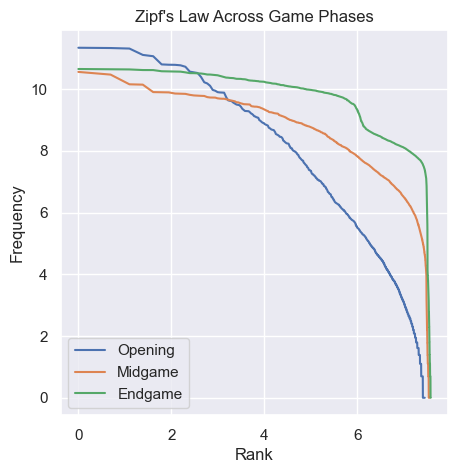

In [39]:
plt.figure(figsize=(5, 5))

zipf_plot(all_opening_moves, "Opening")
zipf_plot(all_midgame_moves, "Midgame")
zipf_plot(all_endgame_moves, "Endgame")

plt.title("Zipf's Law Across Game Phases")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.show()

As expected the exponent for the opening phase is higher than the other two, but from the plot we can see that none of the curves resemble a straight line so no phase is actually similar to a natural language.

As a last analysis it is computed the exponent for every move up to a number of moves (Zipf's exponent for the first N moves of all games) and see if any slice of the move language is close to a natural language.

In [40]:
def computeZipfExponentPerMoveNumber(df, move_number):
    moves = df['Moves'].apply(lambda x: x[move_number-1] if len(x) >= move_number else None)
    moves = moves.dropna()
    move_counts = Counter(moves)
    sorted_move_counts = move_counts.most_common()
    move_ranks = range(1, len(sorted_move_counts) + 1)
    move_frequencies = [count for move, count in sorted_move_counts]
    log_move_ranks = np.log(move_ranks)
    log_move_freqs = np.log(move_frequencies)
    move_coeffs = np.polyfit(log_move_ranks, log_move_freqs, 1)
    move_slope = move_coeffs[0]
    return abs(move_slope)

maxLegths = max(len_games)
zipf_exponents = []
for move_number in tqdm.tqdm(range(1, maxLegths + 1)):
    exponent = computeZipfExponentPerMoveNumber(df, move_number)
    zipf_exponents.append(exponent)

100%|██████████| 833/833 [00:14<00:00, 57.41it/s]


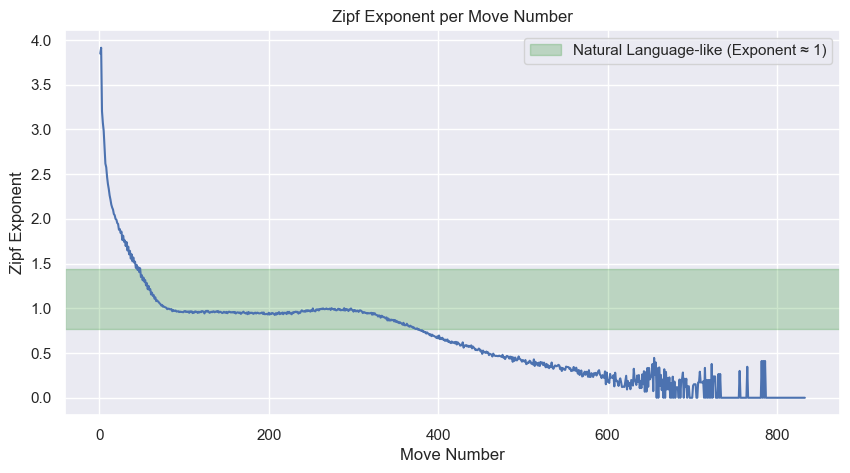

In [41]:
#Plot the Zipf exponents
plt.figure(figsize=(10, 5))
plt.plot(range(1, maxLegths + 1), zipf_exponents, markersize=2)
plt.title("Zipf Exponent per Move Number")
plt.xlabel("Move Number")
plt.ylabel("Zipf Exponent")
plt.axhspan(0.77, 1.44, color='green', alpha=0.2, label='Natural Language-like (Exponent ≈ 1)')
plt.legend()
plt.show()

From the plot, it is evident that the exponent computed using the first N moves of all games (with N between approximately 80 and 300) is very close to one, which suggests it can be approximated to that of a natural language.

#### N-grams analysis

Another interesting analysis to perform in order to answer the question is the n-grams analysis.

N-grams are contiguous sequences of N words that could indicate regularities in languages (words that often appear with the same words).

The analysis to perform now is the following:

`Is the chess language more uniform than a natural language (moves appear frequently near the same moves) or are the two languages types comparable?`

In [42]:
import chess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from typing import List, Tuple
import seaborn as sns
sns.set_theme()
from nlpChess.utils.DatasetLoader import loadConcatenatedDataset, loadConcatenatedShakespeareDataset

Load the data and remove the fifth character (promotions) from the moves

In [44]:
ds = loadConcatenatedDataset()
df = ds.to_pandas()


def removeFifthChar(string):
    if len(string) < 5:
        return string
    return string[:4]

#Apply the function to the 'moves' column
df['moves'] = df['Moves'].apply(removeFifthChar)

Concatanate all moves from all games into a single list

In [45]:
moves = np.concatenate(df['moves'].values)
moves

array(['e2e4', 'g7g6', 'g1f3', ..., 'g8f6', 'c2c4', 'g7g6'], dtype=object)

Load the Shakespear dataset

In [46]:
dsShakespeare = loadConcatenatedShakespeareDataset()
dfShakespeare = dsShakespeare.to_pandas()
dfShakespeare.head()

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,19217,19218,Antony and Cleopatra,9.0,2.1.33,POMPEY,"How now, Varrius!"
1,99413,99414,Troilus and Cressida,32.0,1.2.66,CRESSIDA,"Ay, if I ever saw him before and knew him."
2,104667,104668,Twelfth Night,86.0,3.4.193,VIOLA,With the same 'havior that your passion bears
3,41989,41990,Henry VIII,41.0,3.2.121,SUFFOLK,"May be, he hears the king"
4,36553,36554,Hamlet,119.0,5.2.312,HAMLET,"Nay, come, again."


Concatenate all lines of all plays.

In [47]:
lines = dfShakespeare['PlayerLine'].tolist()
lines = ' '.join(lines)
lines[:500]

"How now, Varrius! Ay, if I ever saw him before and knew him. With the same 'havior that your passion bears May be, he hears the king Nay, come, again. Nor in a way so chaste, since my desires My lord, Fie on sinful fantasy! I warrant thee. Of ill-shaped fishes, and about his shelves Prithee, do, Jack. So bad an instrument: his name's Parolles. Your franchises, whereon you stood, confined The rest is labour, which is not used for you: Hot, hot, and moist: this hand of yours requires Why might not"

Remove stopwords and punctuation from Shakespear to have better results on n-grams

In [48]:
lines = lines.lower()
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def removeStopwords(text: str) -> str:
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

import string
def removePunctuation(text: str) -> str:
    return text.translate(str.maketrans('', '', string.punctuation))

lines = removeStopwords(lines)
lines = removePunctuation(lines)
lines = lines.split()
lines[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['now',
 'varrius',
 'ay',
 'ever',
 'saw',
 'knew',
 'him',
 'havior',
 'passion',
 'bears']

Let's define a method to compute the most common n-grams in a sequence of tokens.

In [49]:
def most_common_ngrams(moves: List[str], n: int, top_k: int = 10) -> List[Tuple[Tuple[str], int]]:
    ngrams = (tuple(moves[i:i+n]) for i in range(len(moves) - n + 1))
    counter = Counter(ngrams)
    return counter.most_common(top_k), len(moves) - n + 1


Let's try computing and plotting the top 10 4-grams both for chess and Shakespear to compare the two.

In [50]:
top_ngrams_shakespear, _ = most_common_ngrams(lines, 4, 10)
top_ngrams_chess, _ = most_common_ngrams(moves, 4, 10)

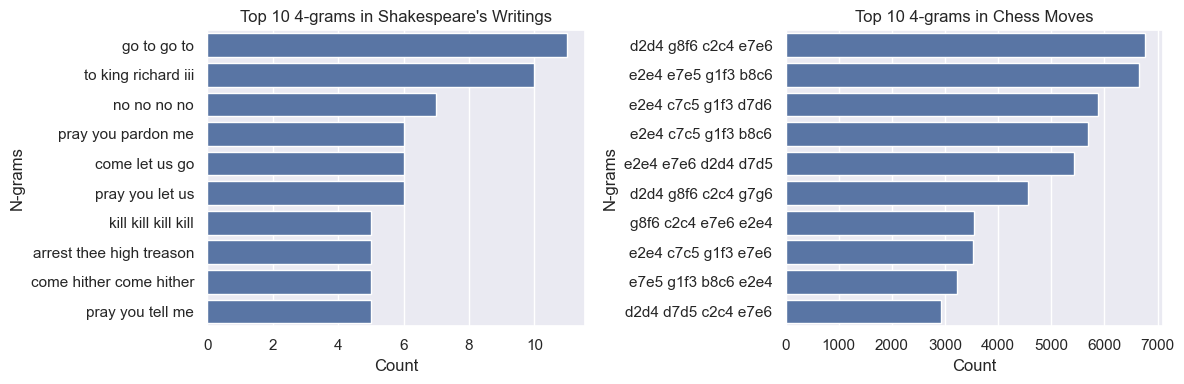

In [51]:
# plot the top 10 ngrams side by side
def plot_top_ngrams_side_by_side(ngrams1, title1, ngrams2, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False)
    
    ngram_labels1 = [' '.join(ngram) for ngram, _ in ngrams1]
    counts1 = [count for _, count in ngrams1]
    sns.barplot(x=counts1, y=ngram_labels1, ax=axes[0])
    axes[0].set_title(title1)
    axes[0].set_xlabel('Count')
    axes[0].set_ylabel('N-grams')
    
    ngram_labels2 = [' '.join(ngram) for ngram, _ in ngrams2]
    counts2 = [count for _, count in ngrams2]
    sns.barplot(x=counts2, y=ngram_labels2, ax=axes[1])
    axes[1].set_title(title2)
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('N-grams')
    
    plt.tight_layout()
    plt.show()

plot_top_ngrams_side_by_side(
    top_ngrams_shakespear, "Top 10 4-grams in Shakespeare's Writings",
    top_ngrams_chess, "Top 10 4-grams in Chess Moves"
)

It should be interesting to visualize the n-grams for chess on a checkboard to see if any meaningful patterns or structures emerge. Let's try it.

Top 0 4-gram: ('d2d4', 'g8f6', 'c2c4', 'e7e6'), Count: 6771


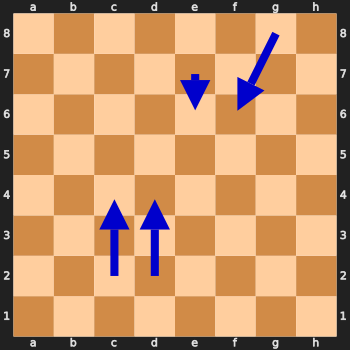

Top 1 4-gram: ('e2e4', 'e7e5', 'g1f3', 'b8c6'), Count: 6652


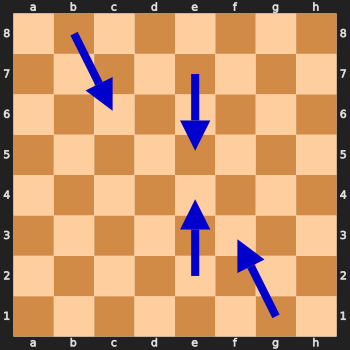

Top 2 4-gram: ('e2e4', 'c7c5', 'g1f3', 'd7d6'), Count: 5879


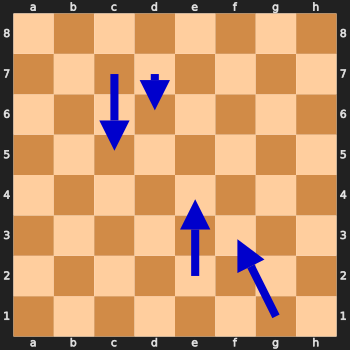

Top 3 4-gram: ('e2e4', 'c7c5', 'g1f3', 'b8c6'), Count: 5695


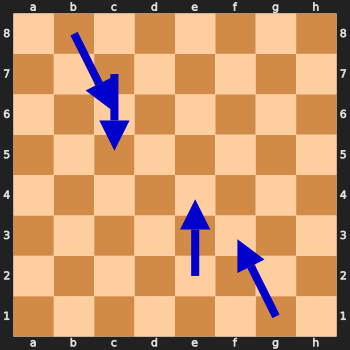

Top 4 4-gram: ('e2e4', 'e7e6', 'd2d4', 'd7d5'), Count: 5434


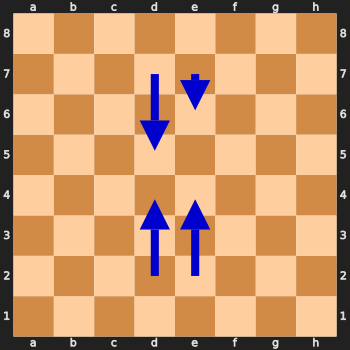

Top 5 4-gram: ('d2d4', 'g8f6', 'c2c4', 'g7g6'), Count: 4568


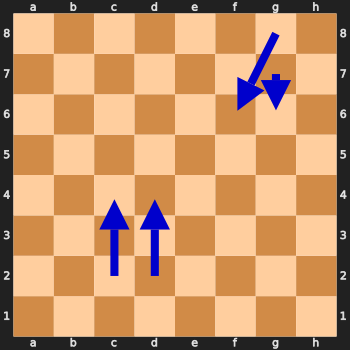

Top 6 4-gram: ('g8f6', 'c2c4', 'e7e6', 'e2e4'), Count: 3537


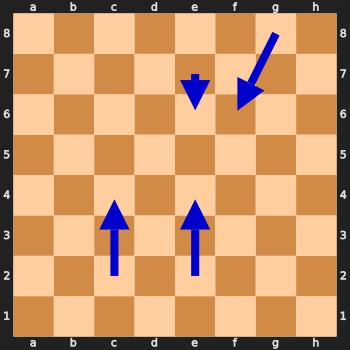

Top 7 4-gram: ('e2e4', 'c7c5', 'g1f3', 'e7e6'), Count: 3530


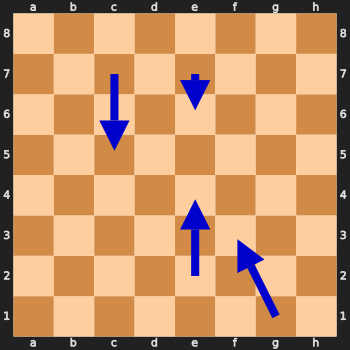

Top 8 4-gram: ('e7e5', 'g1f3', 'b8c6', 'e2e4'), Count: 3230


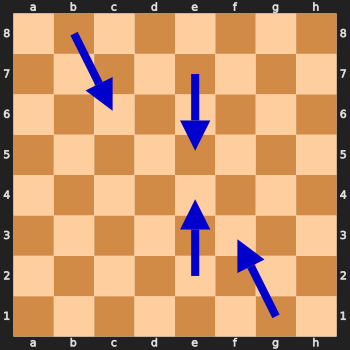

Top 9 4-gram: ('d2d4', 'd7d5', 'c2c4', 'e7e6'), Count: 2918


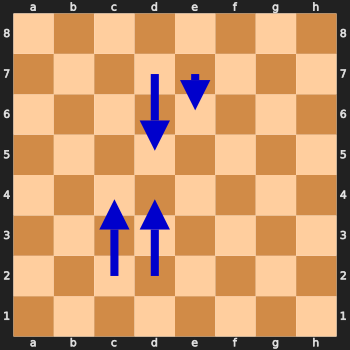

In [52]:
from nlpChess.utils.MovePlotter import MovePlotter

for i, (ngram, count) in enumerate(top_ngrams_chess):
    plotter = MovePlotter(f"Top {i} 4-gram in Chess Moves")
    print(f"Top {i} 4-gram: {ngram}, Count: {count}")
    for move in ngram:
        plotter.addMove(move)
    plotter.plot(justBoard=True)

The structure of these moves together resemble opening structure.

For example the first n-gram plotted is exactly the start of the [Nimzo-Indian Defense](https://www.chess.com/openings/Nimzo-Indian-Defense)

The second one is the [Italian Game](https://www.chess.com/openings/Italian-Game) and so on.

This observation is meaningful, it suggests that the most structured and frequently repeated part of chess games is the opening phase.

It's also evident that the count of n-grams found is much bigger for chess. 

This could indicate that the chess language is more uniform but we have to normalize it taking into account the different lenght of the two dataset and trying it for different Ns.

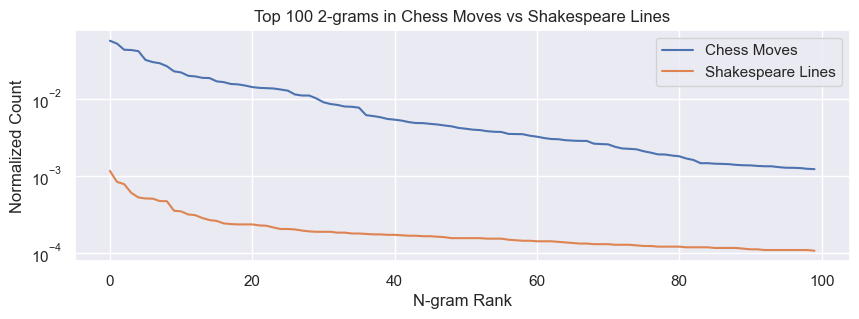

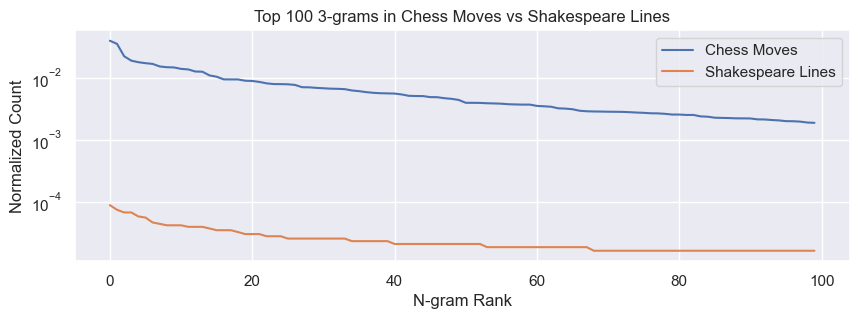

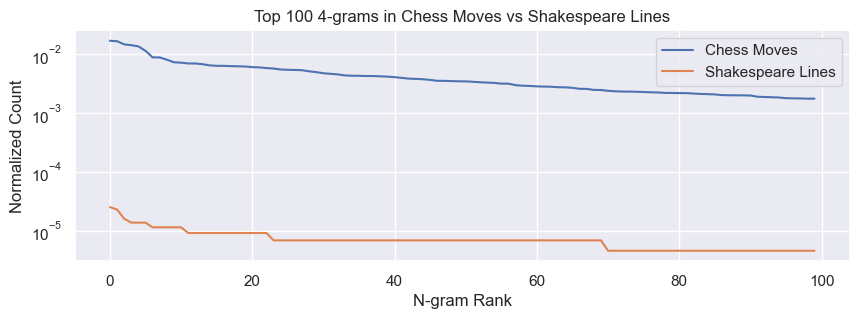

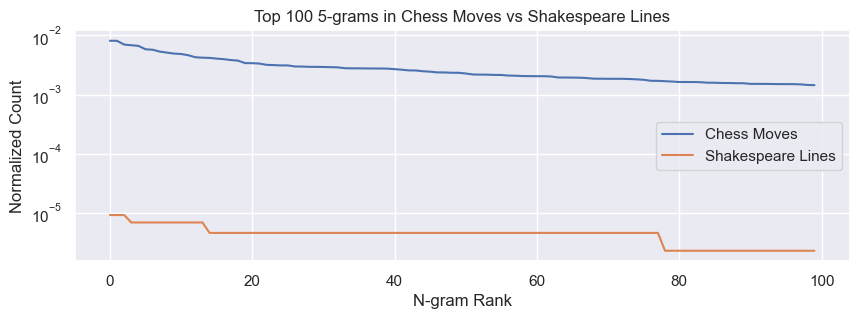

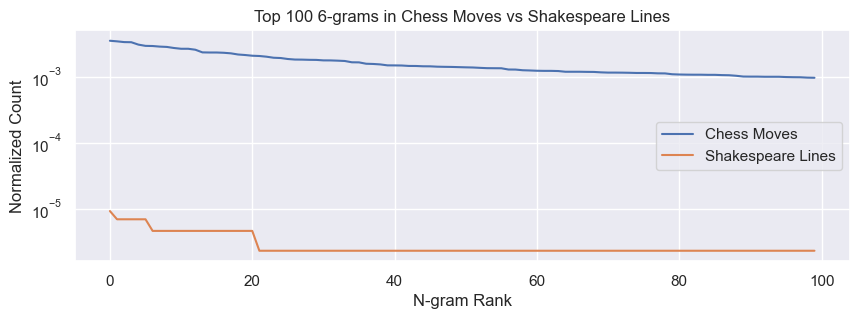

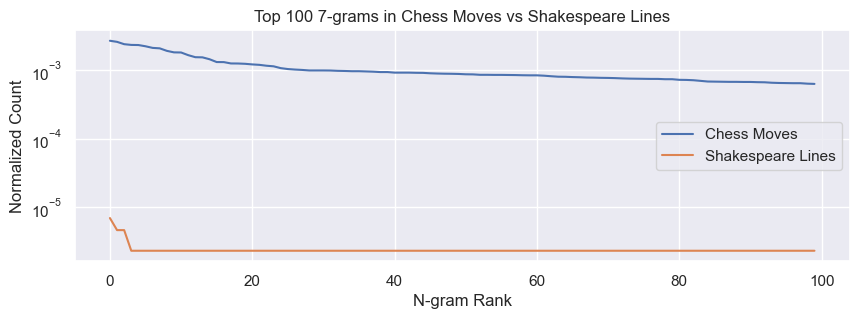

In [53]:
topK = 100

for n in range(2, 8):
    ngramsChess, nNgramsChess = most_common_ngrams(moves, n, topK)
    ngramsShakespear, nNgramsShakespear = most_common_ngrams(lines, n, topK)

    plt.figure(figsize=(10, 3))
    plt.semilogy(range(topK), [count/nNgramsChess for _, count in ngramsChess], label='Chess Moves')
    plt.semilogy(range(topK), [count/nNgramsShakespear for _, count in ngramsShakespear], label='Shakespeare Lines')
    plt.title(f'Top {topK} {n}-grams in Chess Moves vs Shakespeare Lines')
    plt.xlabel('N-gram Rank')
    plt.ylabel('Normalized Count')
    # plt.xticks(range(topK), [f'#{i+1}' for i in range(topK)])
    plt.legend()
    plt.show()

Even normalizing the count of N-grams and plotting the top 100 n-grams it's evident the higher regularity in the chess language with respect to the english one.

Let's now see if some of the famous openings are in the top n-grams (respectively to their lenght).

The most frequent openings are:

In [54]:
famous_openings = {
    "Ruy Lopez (Spanish Opening)": ["e2e4", "e7e5", "g1f3", "b8c6", "f1b5"],
    "Italian Game": ["e2e4", "e7e5", "g1f3", "b8c6", "f1c4"],
    "Sicilian Defense": ["e2e4", "c7c5"],
    "Open Sicilian": ["e2e4", "c7c5", "g1f3", "d7d6", "d2d4", "c5d4", "f3d4"],
    "French Defense": ["e2e4", "e7e6"],
    "Caro-Kann Defense": ["e2e4", "c7c6"],
    "Queen's Gambit": ["d2d4", "d7d5", "c2c4"],
    "King's Indian Defense": ["d2d4", "g8f6", "c2c4", "g7g6"],
    "Slav Defense": ["d2d4", "d7d5", "c2c4", "c7c6"],
    "Scandinavian Defense": ["e2e4", "d7d5"],
    "English Opening": ["c2c4"],
    "King's Gambit": ["e2e4", "e7e5", "f2f4"],
    "Nimzo-Indian Defense": ["d2d4", "g8f6", "c2c4", "e7e6", "b1c3", "f8b4"],
}


Let's check if the n-grams represent famous openings

In [55]:
#check if the openings are in the top 5 ngrams
def check_openings_in_ngrams(openings: dict, ngrams:List[Tuple]) -> List[str]:
    openings_list = []
    for opening, moves in openings.items():
        moves_str = ' '.join(moves)
        for i, (ngram, count) in enumerate(ngrams):
            if moves_str in ' '.join(ngram):
                openings_list.append({"Opening": opening, "Moves": moves_str, "Rank":i, "Count": count})
                break
            
    return openings_list

In [ ]:
check_openings_in_ngrams(famous_openings, top_ngrams_chess)

[{'Opening': 'Sicilian Defense',
  'Moves': 'e2e4 c7c5',
  'Rank': 2,
  'Count': 5879},
 {'Opening': 'French Defense', 'Moves': 'e2e4 e7e6', 'Rank': 4, 'Count': 5434},
 {'Opening': "Queen's Gambit",
  'Moves': 'd2d4 d7d5 c2c4',
  'Rank': 9,
  'Count': 2918},
 {'Opening': "King's Indian Defense",
  'Moves': 'd2d4 g8f6 c2c4 g7g6',
  'Rank': 5,
  'Count': 4568},
 {'Opening': 'English Opening', 'Moves': 'c2c4', 'Rank': 0, 'Count': 6771}]

It is possible to see that some of the most famous openings are present in the top n-grams in chess.

Let's visualize it on a plot.

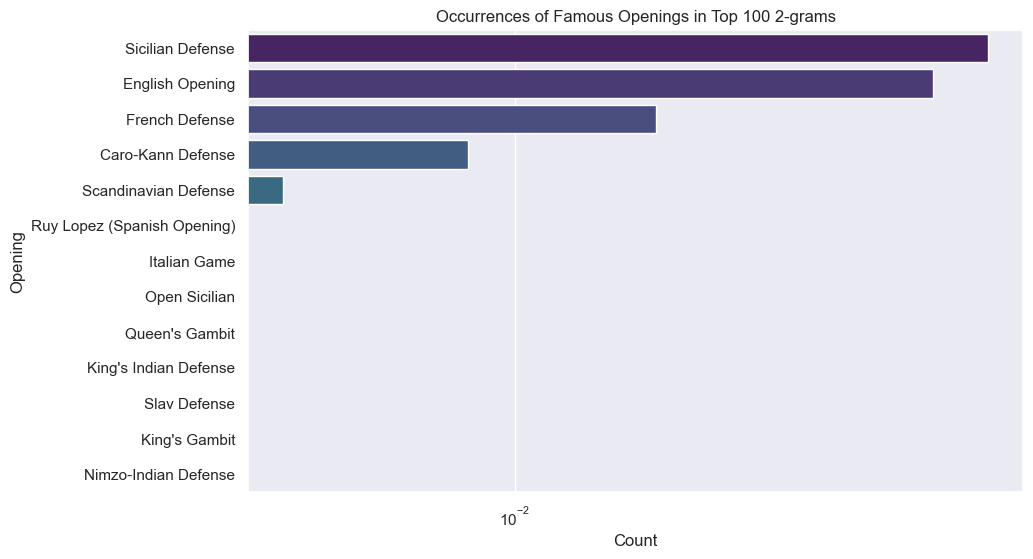

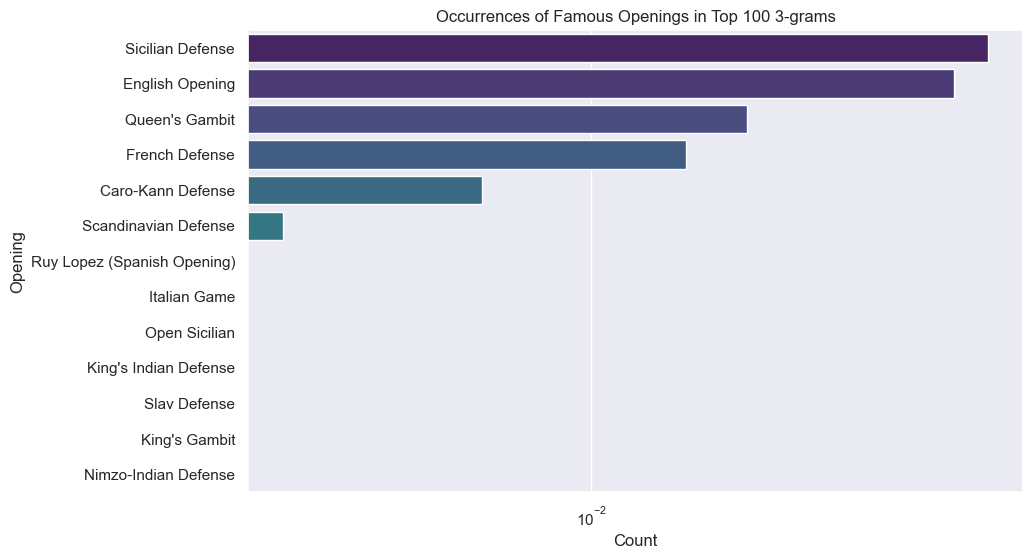

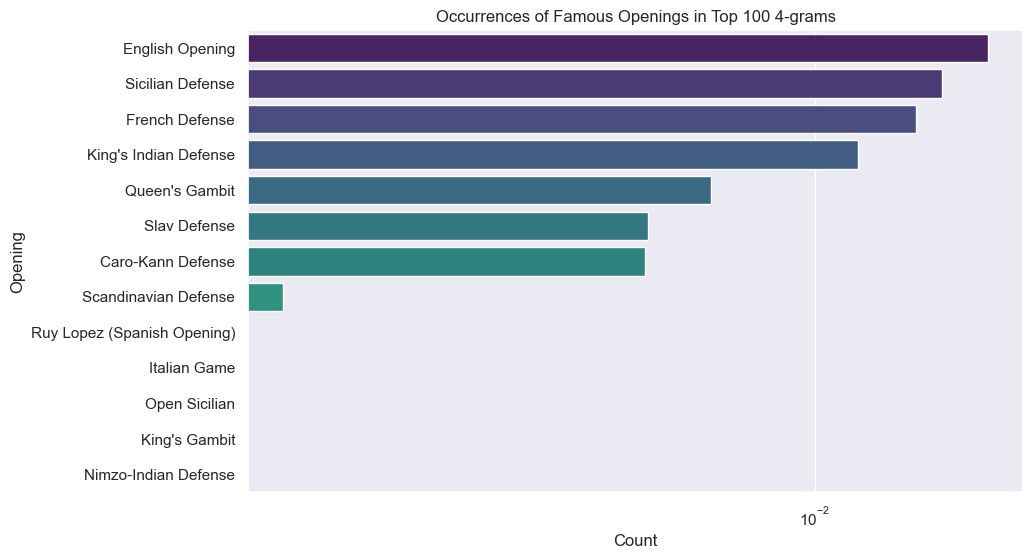

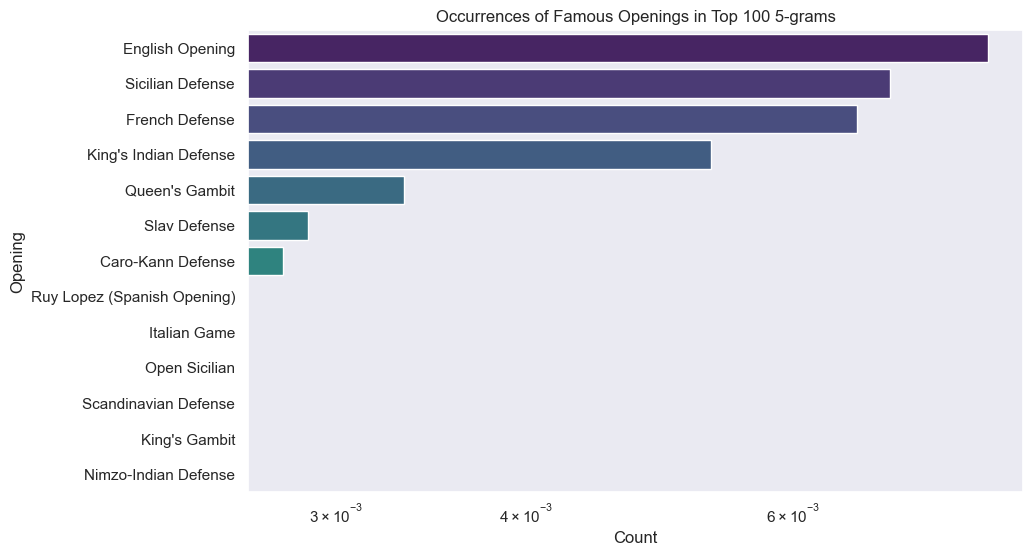

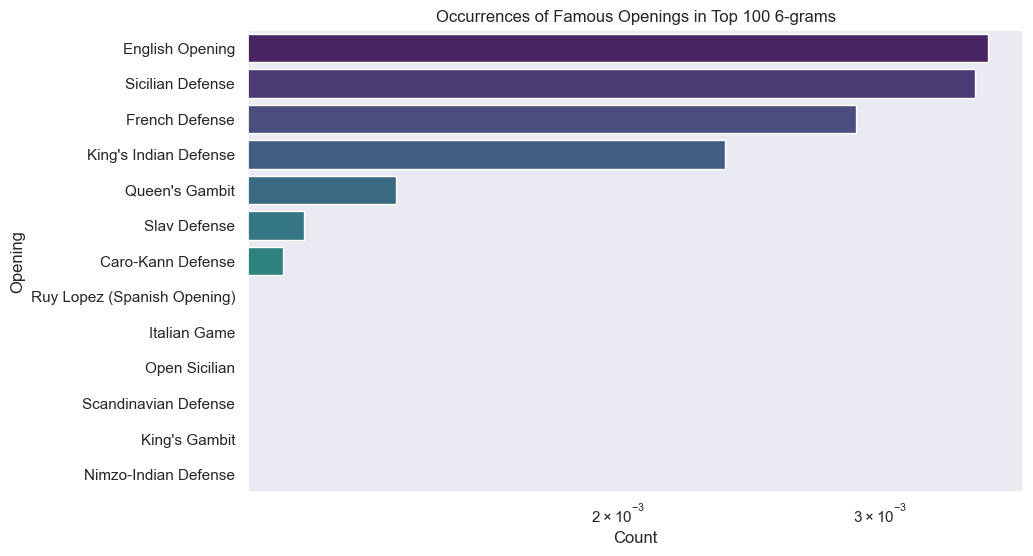

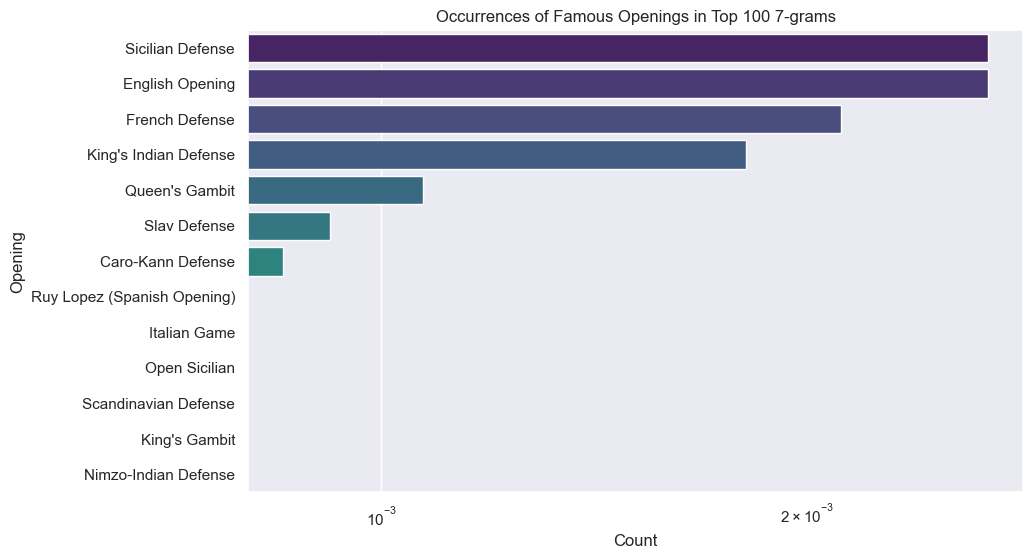

In [ ]:
for n in range(2, 8):
    # Plot the openings in ngrams
    ngramsChess, nNgramsChess = most_common_ngrams(moves, n, 100)
    openings_in_ngrams = check_openings_in_ngrams(famous_openings, ngrams=ngramsChess)

    #Compute the total count per opening
    opening_counts = []
    for opening in famous_openings:
        moves_str = ' '.join(famous_openings[opening])
        count = sum(r['Count'] for r in openings_in_ngrams if opening == r['Opening']) / nNgramsChess
        opening_counts.append((opening, count))

    # Convert to DataFrame for plotting
    openings_count_df = pd.DataFrame(opening_counts, columns=['Opening', 'Count']).sort_values('Count', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Opening', data=openings_count_df, hue='Opening', palette='viridis', legend=False)
    plt.title(f'Occurrences of Famous Openings in Top 100 {n}-grams')
    plt.xlabel('Count')
    plt.ylabel('Opening')
    plt.xscale('log')
    plt.show()


The plots are quiet interesting because they identify a lot of different openings in the top n-grams.


Obviously the fact that English Opening is at the top of almost every plot is also given by the fact that it consists of just one move, but it is also interesting to see that sometimes the Sicilian Defence is more frequent than English Opening even if it's longer.